In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pathlib import Path
import imageio
from tqdm import tqdm_notebook as tqdm

In [3]:
source = Path("~/data/unlabelled/1cut/").expanduser()
vids = sorted(source.glob("*"))

In [4]:
vid = vids[61]

In [5]:
cap = imageio.get_reader(vid)
frames = [x for x in tqdm(cap)]
cap.close()

In [6]:
from config import tracker2, bokeh_viz

In [7]:
hands = [tracker2(x) for x in tqdm(frames)]

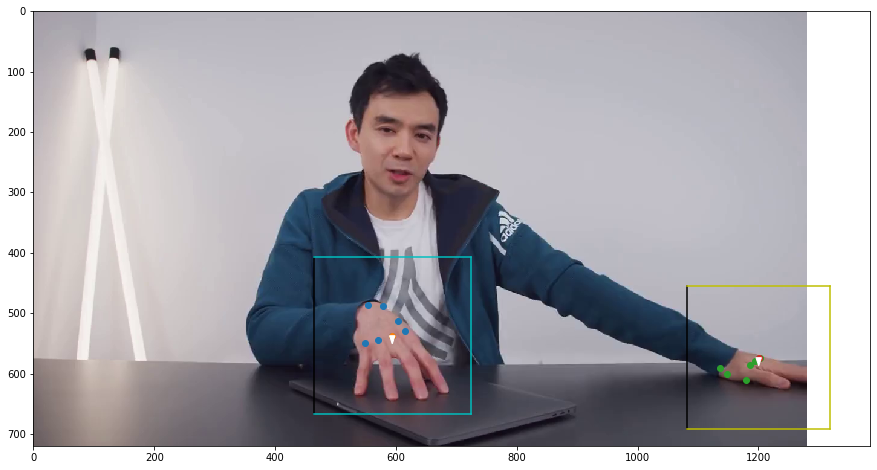

In [8]:
i = 0
c = [
        ['k','c','c','c'],
        ['k','y','y','y']
]

plt.figure(figsize=(15,15))
plt.imshow(frames[i])

for j,h in enumerate(hands[i]):
    crd = h['lm']
    box = h['bbox']
    plt.scatter(crd[:,0], crd[:,1])
    plt.scatter(crd[[2],0], crd[[2],1])
    
    plt.arrow(*crd[2], *h['dydx'], color='w', width=3)

    for i in range(0,4):
        plt.plot(box[[i, (i+1) % 4], 0], box[[i, (i+1) % 4], 1], c=c[j][i])

In [10]:
def draw_detect(img, hands):
    c = [(0,255,255), (255,255,0)] * 10
    
    for j,h in enumerate(hands):
        crd = h['lm'].astype('int')
        box = h['bbox'].astype('int')
        dydx = h['dydx'].astype('int')
        center = h['lm'][2].astype('int')
        
        cv2.arrowedLine(img, tuple(center-dydx), tuple(center), (255,255,255), 5, tipLength=0.2)
        
        for i in range(0,4):
            beg = tuple(box[i])
            end = tuple(box[(i+1) % 4])
            cv2.line(img, tuple(box[i]), tuple(box[(i+1) % 4]), c[j], 3)
    return img

In [11]:
save_path = vid.as_posix().replace("1cut", "2boxed")

writer = imageio.get_writer(save_path, fps=30)

for frame, hand in tqdm(zip(frames, hands), total=len(frames)):
    writer.append_data(draw_detect(frame, hand))

writer.close()

In [12]:
def get_pad(hands, img_shape):
    assert len(img_shape) == 2
    
    boxes = np.c_[[x['bbox'] for x in hands]].reshape(-1, 2)
    
    max_ = boxes.max(axis=0).astype('int')+1
    min_ = boxes.min(axis=0).astype('int')-1
    
    
    p_min = np.maximum(-min_, 0)
    p_max = np.maximum(max_ - img_shape[::-1], 0)
    
    new_boxes = [(x['bbox'] + p_min).astype('int') for x in hands]
    
    return ((p_min[1],p_max[1]), (p_min[0], p_max[0]), (0,0)), new_boxes

In [13]:
def crop_hands(frame, hands):
    pad, boxes = get_pad(hands, frame.shape[:2])
    padded = np.pad(frame, pad, mode='constant')
    
    res = []
    
    for b in boxes:
        slc0 = slice(b[0,1], b[1,1])
        slc1 = slice(b[0,0], b[2,0])
        res.append(cv2.resize(padded[slc0, slc1], (256,256)))
    return res

In [14]:
cropped = [crop_hands(f, h) for f,h in tqdm(zip(frames, hands), total=len(hands))]

In [15]:
seq = [
    [[]], #hand 0
    [[]],  #hand 1 
]

In [16]:
n_prev = 2
for crp in cropped:
    if n_prev != len(crp):
        for s, h in zip(seq, crp):
            s.append([])
        n_prev = len(crp)

    for s,h in zip(seq, crp):
        s[-1].append(h)

In [17]:
bokeh_viz(seq[0][0])

Loading BokehJS ...

IntSlider(value=0, max=288)

In [22]:
crd = tracker2.track_record[162]['inp_hands']

In [34]:
tracker2.track_record[162]['hand_res']

array([[[424.88785982, 515.83943129],
        [454.88175392, 541.87680259],
        [430.54768801, 555.20655394],
        [413.9364481 , 567.56253242],
        [402.38063335, 577.8485775 ],
        [461.4631775 , 508.73768806],
        [490.6823802 , 526.35767698]],

       [[937.57197499, 477.53043234],
        [972.97437221, 491.59707129],
        [988.7990725 , 498.3111769 ],
        [996.32055402, 505.7976526 ],
        [998.79178882, 512.95814455],
        [921.01904273, 475.48914969],
        [930.01099467, 488.87252629]]])

In [42]:
idx = tracker2.track_record[162]['hands not updated']

In [45]:
tracker2.track_record[162]['inp_hands']

array([[[952.05476403, 531.14610434],
        [912.35321999, 453.81252766],
        [943.44412327, 450.58387756],
        [971.05302095, 457.76260376],
        [995.80016613, 470.56833744],
        [918.2311821 , 534.77870941],
        [896.58092499, 517.40959167]]])

In [43]:
tracker2.track_record[162]['hand_res'][idx]

array([[[937.57197499, 477.53043234],
        [972.97437221, 491.59707129],
        [988.7990725 , 498.3111769 ],
        [996.32055402, 505.7976526 ],
        [998.79178882, 512.95814455],
        [921.01904273, 475.48914969],
        [930.01099467, 488.87252629]]])

In [35]:
tracker2.track_record[161]['hand_res']

array([[[424.88785982, 515.83943129],
        [454.88175392, 541.87680259],
        [430.54768801, 555.20655394],
        [413.9364481 , 567.56253242],
        [402.38063335, 577.8485775 ],
        [461.4631775 , 508.73768806],
        [490.6823802 , 526.35767698]],

       [[907.62168169, 535.80705643],
        [943.02407891, 549.87369537],
        [958.8487792 , 556.58780098],
        [966.37026072, 564.07427669],
        [968.84149551, 571.23476863],
        [891.06874943, 533.76577377],
        [900.06070137, 547.14915037]]])

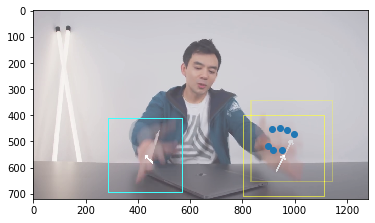

In [32]:
plt.imshow(frames[162], alpha=0.5)
plt.imshow(frames[161], alpha=0.5)

plt.scatter(crd[0][:,0], crd[0][:,1])

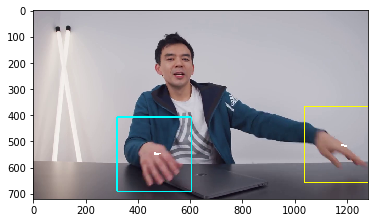

In [16]:
plt.imshow(
    draw_detect(frames[17].copy(), hands[17])
)

In [ ]:
a = tracker2.sizes.copy()

In [ ]:
vid